In [9]:
import nltk
nltk.download('stopwords')

from importlib.metadata import version
import tensorflow
import summa
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


3.6.5
2.6.0
1.3.3
1.2.0


# Step 1. 데이터 수집하기

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
57619,Bangkok's top-rated Indian eatery awarded two ...,A top-rated Indian eatery in Bangkok has been ...
63362,Army to build overbridge at Mumbai's Elphinsto...,The Indian Army's military wing will help buil...
62080,Cricketer changes jersey no. from 2 to 0 for '...,Bangladesh cricketer Mashrafe Mortaza said he ...
6567,Mars mission may shorten astronauts' lives by ...,A research presented at a Moscow conference ha...
73631,Maha Police set up 24/7 helpline for cattle tr...,The Maharashtra Police has reportedly set up a...
69678,"3 cops to protect each VIP, 1 for 663 common p...",Nearly three policemen on an average in India ...
25488,3 killed in collision between two planes over ...,At least three people were killed on Tuesday a...
3091,Tottenham Ladies player says opponent made mon...,The Football Association has launched an inves...
80835,Canadian fisherman killed by whale moments aft...,A Canadian lobster fisherman died after gettin...
56957,"Maoists kill two in Andhra, claim they were po...",Maoists in Andhra Pradesh's Visakhapatnam kill...


# Step 2. 데이터 전처리하기(추상적 요약)

## 데이터 분석, 정제, 정규화 및 불용어 제거

In [4]:
data.shape

(98401, 2)

In [5]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
print(data.isnull().sum())
#data.dropna(axis=0, inplace=True) #불필요

headlines    0
text         0
dtype: int64


In [7]:
# 정규화 사전 from 'https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python'

contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
#print(stopwords.words('english'))

불용어 개수 : 179


In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []

for text in data['text']:
    clean_text.append(preprocess_sentence(text))
    
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [13]:
# 전체 Headline 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
clean_summary = []

for headline in data['headlines']:
    clean_summary.append(preprocess_sentence(headline, False))

print("Headlines 전처리 후 결과: ", clean_summary[:5])

Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [14]:
# 전처리 과정에서 모든 단어가 제거된 빈 샘플이 생길 수 있음
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('전처리 후 생긴 null 개수 : \n', data.isnull().sum())
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전처리 후 생긴 null 개수 : 
 headlines    0
text         0
dtype: int64
전체 샘플수 : 98360


In [16]:
# 전처리 오래 걸리니까 혹시 커널 초기화될까봐 백업

with open(r'246013_data_clean_text.txt', 'w') as f:
    for text in data['text']:
        f.write("%s\n" % text)
    print('Text Done')
    
with open(r'240613_data_clean_headline.txt', 'w') as f:
    for headline in data['headlines']:
        f.write("%s\n" % headline)
    print('headlines Done')

Text Done
headlines Done


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


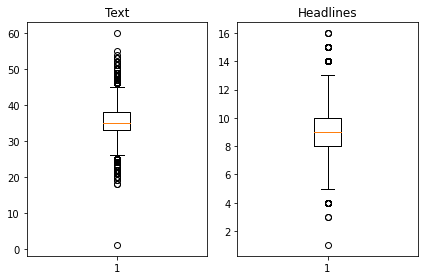

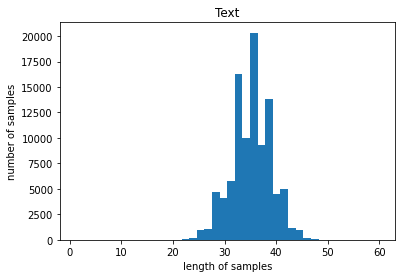

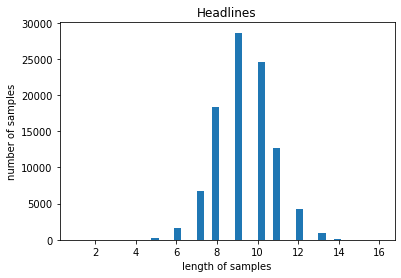

In [23]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = np.array([len(s.split()) for s in data['text']])
summary_len = np.array([len(s.split()) for s in data['headlines']])

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
max_text_len = int(np.mean(text_len) + 2 * np.std(text_len))
max_headlines_len = int(np.mean(summary_len) + 2 * np.std(summary_len))

print('max text length : ', max_text_len)
print(f'전체 text의 {np.sum(text_len <= max_text_len) / len(text_len):.4f}이 maxlen 설정값 이내에 포함')

print('max haedline length : ', max_headlines_len)
print(f'전체 headline의 {np.sum(summary_len <= max_headlines_len) / len(summary_len):.4f}이 maxlen 설정값 이내에 포함')

max text length :  42
전체 text의 0.9750이 maxlen 설정값 이내에 포함
max haedline length :  12
전체 headline의 0.9880이 maxlen 설정값 이내에 포함


In [31]:
data['text'].apply(lambda x: len(x.split())<=max_text_len).sum()/len(data['text'])

0.9750305002033347

In [32]:
data['headlines'].apply(lambda x: len(x.split())<=max_headlines_len).sum()/len(data['headlines'])

0.9880337535583571

In [33]:
# text, headlines의 max length를 넘는 샘플 제외

cond1 = data['text'].apply(lambda x: len(x.split())<=max_text_len)
data = data.loc[cond1]

cond2 = data['headlines'].apply(lambda x: len(x.split())<=max_headlines_len)
data = data.loc[cond2]
data

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...
...,...,...
98396,crpf jawan axed to death by maoists in chhatti...,crpf jawan tuesday axed death sharp edged weap...
98397,first song from sonakshi sinha noor titled uff...,uff yeh first song sonakshi sinha starrer upco...
98398,the matrix film to get reboot reports,according reports new version science fiction ...
98399,snoop dogg aims gun at clown dressed as trump ...,new music video shows rapper snoop dogg aiming...


## 데이터셋 분리 & 인코딩

In [34]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [35]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [36]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[34007 71346 52782 ...  9581 30361 92410]


In [37]:
# 잘 섞고
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [38]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18950


In [39]:
# 8:2로 나눠주기
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 75804
훈련 레이블의 개수 : 75804
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


In [40]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [41]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67968
등장 빈도가 6번 이하인 희귀 단어의 수: 46292
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21676
단어 집합에서 희귀 단어의 비율: 68.10852165725048
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5588190125453627


In [42]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [43]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[223, 1179, 605, 69, 1, 2, 502, 7818, 745, 2189, 2180, 5526, 336, 1227, 47, 905, 1227, 47, 476, 2, 959, 70, 1480, 979, 72, 1234, 2, 2189, 2180, 6217, 5058, 4396, 223, 1], [84, 539, 85, 613, 17, 2275, 3036, 14440, 1365, 6760, 5970, 222, 88, 51, 29, 8743, 539, 1330, 27, 2646, 539, 259, 1330, 539, 176, 474, 2152, 346, 597, 169, 10, 109, 293, 924], [95, 8069, 1246, 72, 30, 1395, 15, 2778, 1, 2741, 1014, 3122, 208, 735, 892, 96, 4301, 120, 1014, 9440, 1165, 2418, 1, 10968, 2725, 3068, 59, 964, 893, 72]]


In [44]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [45]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29636
등장 빈도가 5번 이하인 희귀 단어의 수: 19386
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10250
단어 집합에서 희귀 단어의 비율: 65.41368605749763
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.757984218095931


In [46]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 46, 10, 2649, 1336, 165, 585, 40, 13, 1839, 1840, 3580], [1, 707, 615, 592, 14, 25, 217, 5072], [1, 3085, 2496, 3, 2074, 888, 7, 64, 11, 5762], [1, 46, 518, 3230, 5, 548, 96, 4169, 2497], [1, 983, 697, 30, 19, 179, 8618, 344, 1524]]
target
decoder  [[46, 10, 2649, 1336, 165, 585, 40, 13, 1839, 1840, 3580, 2], [707, 615, 592, 14, 25, 217, 5072, 2], [3085, 2496, 3, 2074, 888, 7, 64, 11, 5762, 2], [46, 518, 3230, 5, 548, 96, 4169, 2497, 2], [983, 697, 30, 19, 179, 8618, 344, 1524, 2]]


In [47]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 75803
훈련 레이블의 개수 : 75803
테스트 데이터의 개수 : 18950
테스트 레이블의 개수 : 18950


In [49]:
# 패딩
text_max_len = max_text_len
summary_max_len = max_headlines_len
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

# Step 3. 어텐션 메커니즘 사용하기(추상적 요약)

In [177]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
#encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h3, state_c3 = encoder_lstm3(encoder_output2)

# 최종 인코더 상태
encoder_states = [state_h3, state_c3]

# 모델 출력
print(encoder_outputs)
print(encoder_states)

KerasTensor(type_spec=TensorSpec(shape=(None, 42, 256), dtype=tf.float32, name=None), name='lstm_6/PartitionedCall:1', description="created by layer 'lstm_6'")
[<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_6')>, <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_6')>]


In [178]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
#decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

In [179]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 42, 128)      2560000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 42, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [53]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 42, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 42, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

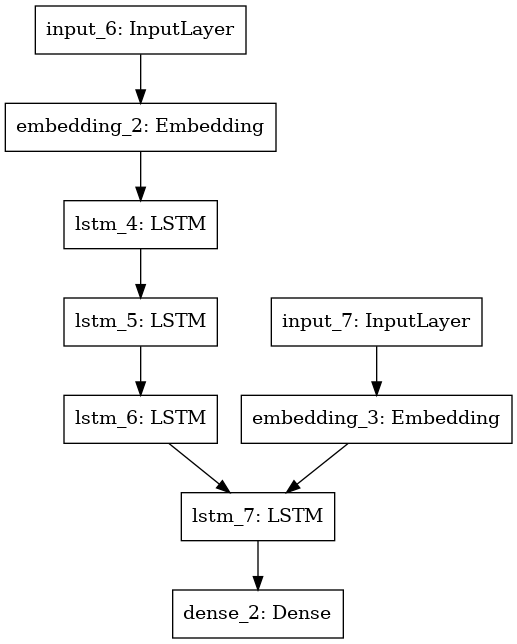

In [180]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [181]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
cp = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[cp, es], epochs=50)

Epoch 1/50
297/297 [==============================] - 86s 264ms/step - loss: 5.7245 - val_loss: 5.4083

Epoch 00001: val_loss improved from inf to 5.40827, saving model to best_lstm_model.h5
Epoch 2/50
297/297 [==============================] - 78s 262ms/step - loss: 5.3435 - val_loss: 5.1649

Epoch 00002: val_loss improved from 5.40827 to 5.16489, saving model to best_lstm_model.h5
Epoch 3/50
297/297 [==============================] - 78s 261ms/step - loss: 5.0691 - val_loss: 4.9148

Epoch 00003: val_loss improved from 5.16489 to 4.91478, saving model to best_lstm_model.h5
Epoch 4/50
297/297 [==============================] - 78s 261ms/step - loss: 4.7799 - val_loss: 4.7391

Epoch 00004: val_loss improved from 4.91478 to 4.73913, saving model to best_lstm_model.h5
Epoch 5/50
297/297 [==============================] - 78s 261ms/step - loss: 4.5571 - val_loss: 4.4916

Epoch 00005: val_loss improved from 4.73913 to 4.49162, saving model to best_lstm_model.h5
Epoch 6/50
297/297 [=========

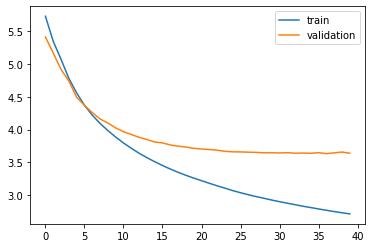

In [182]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [183]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [184]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [185]:
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [190]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Step 4. 실제 결과와 요약문 비교하기(추상적 요약)

In [189]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
# 1 for sostoken, 2 for eostoken
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i not in [0, 1, 2]):
            temp = temp + tar_index_to_word[i]+' '
    return temp

In [191]:
for i in range(50, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : central railway said block churchgate mumbai central pm sunday mumbai official added inconvenience caused due maintenance work track overhead equipment trains delayed minutes fast line services 
실제 요약 : mumbai suburban railway lines blocked for maintenance 


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/functional.py:414 call
        return self._run_internal_graph(
    /opt/conda/lib/python3.9/site-packages/keras/engine/functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:250 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_2 is incompatible with the layer: expected axis -1 of input shape to have value 256 but received input with shape (None, 1, 512)


# Step 5. Summa을 이용해서 추출적 요약해보기

In [67]:
import requests
from summa.summarizer import summarize

In [144]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [70]:
print('Summary:')
print(summarize(text, ratio=0.005))

Summary:
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


## 추상적 요약과 추출적 요약 비교

In [80]:
for i in range(50, 55):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("추상적 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("추출적 요약 :", summarize(seq2text(encoder_input_test[i]), words=20))
    print("\n")

원문 : central railway said block churchgate mumbai central pm sunday mumbai official added inconvenience caused due maintenance work track overhead equipment trains delayed minutes fast line services 
실제 요약 : mumbai suburban railway lines blocked for maintenance 
추상적 요약 :  mumbai railway stations to be ready for delay in trains
추출적 요약 : 


원문 : technology giant apple reportedly planning launch iphone se may year without mm headphone jack smartphone expected feature inch display reduced wireless charging system smartphone may also sport design original iphone se along touch id 
실제 요약 : iphone se to launch in may without headphone jack report 
추상적 요약 :  apple to launch iphone iphone with iphone report
추출적 요약 : 


원문 : renee shah fitness trainer usa received two wheeler driving licence expired date regional transport office andheri maharashtra woman driving licence issuing date august carried expiry date june wanted licence convert nri bank account resident account 
실제 요약 : gives driving l

summa 라이브러리의 summarize 함수를 사용했으나, 요약이 되지 않음.
ratio, words 파라미터 조정해보고 입력 데이터의 길이도 최대 50,000까지 다양하게 시도해보았으나 실패

In [132]:
print(len(text))
summarize(text, ratio=0.005)

35932


'Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.\nTrinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.'

In [156]:
print(len(' '.join(data['text'][:150])))
summarize(' '.join(data['text'][:encoder_input_test150]), ratio=0.005)

38566


''

In [176]:
# 추출적 요약 되는 데이터 없음
for i in range(len(encoder_input_test)):
    summary = summarize(seq2text(encoder_input_test[i]), ratio=0.35)
    if summary:
        print("원문 :", seq2text(encoder_input_test[i]))
        print("실제 요약 :", seq2summary(decoder_input_test[i]))
        print("추상적 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
        print("추출적 요약 :", summarize(seq2text(encoder_input_test[i]), ratio=0.35))
        print("\n")

In [206]:
print(len('. '.join(data['text'][:150])))
summarize('. '.join(data['text'][:150]), words=50)

38715


'government officials wednesday said swine flu outbreak killed people year rajasthan colder weather worsened seasonal outbreak virus country officials added rajasthan recorded third swine flu deaths india jodhpur worst affected area state officials said.'

In [211]:
print(' '.join(data['text'][:10]), '\n')
print(' '.join(data['headlines'][:10]), '\n')
summarize('. '.join(data['text'][:10]), words=100)

saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental death benefit rider life cover age years pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first publicised reads press release is

'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history.\nindia recorded lowest odi total new zealand getting runs overs fourth odi hamilton thursday seven india batsmen dismissed single digit scores number ten batsman yuzvendra chahal top scored india previous lowest odi total new zealand.\ncongress candidate shafia zubair ramgarh assembly seat rajasthan defeating bjp sukhwant singh margin votes bypoll victory congress taken total seats member assembly election ramgarh seat delayed due death sitting mla bsp candidate laxman singh.'

## 회고

* 배운점
  - 문장 요약 모델에 대해 처음으로 배웠다.
  - LSTM 모델 구조를 설계하였다.
* 아쉬운점
  - summa 라이브러리의 한계점(온점으로 나뉜 여러 문장이 필요함)으로 동일한 원문에 대한 추상적 요약과 추출적 요약의 비교를 하지 못했다.
  - summa외에 다른 추출적 요약 라이브러리를 활용해서 실험해봐야겠다.
* 느낀점
  - 처음부터 실험설계를 좀더 확실하게 해서 데이터 전처리 과정에서 필요한 데이터의 백업이 이뤄져야할 것 같다.
  - 데이터 전처리때 추출적 요약에 대해 고려했다면 두 방식의 비교 부분을 쉽게 구현했을 것 같다.
* 어려웠던 점
  - 데이터를 전처리하는 과정에서 형태가 계속 바뀌다보니 헷갈리는 부분이 많았다. 그림으로 도식화해서 데이터의 shape을 따라갈 필요가 있다.
  - 모델 트레이닝에 생각보다 시간이 오래 걸려서 이 부분도 시간 분배와 파라미터 설정 등을 처음부터 잘 신경써야겠다.